In [1]:
!pwd

/Users/ashish1610dhiman/data_projects/bestbuy/notebooks/ashish


In [2]:
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

sys.version

sys.path.append("../../")

# from src.ad_hmm import sku_predict
# from src.ad_stl_model import stl_model
from src.utils import *

In [3]:
%load_ext autoreload 
%autoreload 

### Analyse results

In [7]:
rmse_results = pd.read_excel("../../results/rmse_all_preds_jan_17.xlsx",index_col=0)
rmse_results.head()

,rmse_du_15,mean_du_15,pct_rmse_15,rmse_du_30,mean_du_30,pct_rmse_30,rmse_du_45,mean_du_45,pct_rmse_45,rmse_du_60,...,pct_rmse_prophet,rmse_du_null,mean_du_null,pct_rmse_null,rmse_du_holt,mean_du_holt,pct_rmse_holt,min_rmse,argmin_period,min_period
Encoded_SKU_ID,,,,,,,,,,,,,,,,,,,,,
82,4.722325,0.428571,11.018759,4.840344,0.428571,11.294136,1.102108,0.428571,2.571586,1.419381,...,5.362264,3.605551,0.428571,8.412953,9.753826,0.428571,22.758928,0.911043,5,rmse_du_max
568,4.097124,4.285714,0.955996,3.447670,4.285714,0.804456,3.652836,4.285714,0.852329,3.871231,...,0.595404,5.070926,4.285714,1.183216,3.024439,4.285714,0.705702,2.551733,8,rmse_du_prophet
317,3.766488,0.857143,4.394235,1.362770,0.857143,1.589899,1.784957,0.857143,2.082450,2.104417,...,2.297158,1.069045,0.857143,1.247219,2.363641,0.857143,2.757581,1.069045,9,rmse_du_null
95,3.668447,1.285714,2.853236,1.698949,1.285714,1.321405,3.991151,1.285714,3.104228,3.931648,...,1.743961,1.309307,1.285714,1.018350,1.720612,1.285714,1.338254,1.309307,9,rmse_du_null
340,3.668447,0.714286,5.135825,2.077172,0.714286,2.908041,2.329929,0.714286,3.261901,1.558387,...,0.970033,0.925820,0.714286,1.296148,1.092959,0.714286,1.530142,0.692881,8,rmse_du_prophet


In [9]:
sku_period_dict = rmse_results.reset_index().groupby("min_period")["Encoded_SKU_ID"].apply(list)

### Distribution of category/sub category

In [10]:
train_test = pd.read_csv("../../data/train_validation_marker.csv")
train_test["SALES_DATE"] = pd.to_datetime(train_test["SALES_DATE"])
print (train_test.shape)

(846632, 15)


In [17]:
train_test["if_promo"] = (~train_test["PROMO_PRICE"].isin(["?"])).astype("int")
train_test["if_competitor"] = (~train_test["COMPETITOR_PRICE"].isin(["?"])).astype("int")

train_test["min_sales_price"] = pd.to_numeric(np.where(train_test.if_promo>0, train_test.PROMO_PRICE,\
                                                       train_test.RETAIL_PRICE))

train_test["comp_price_clean"] = pd.to_numeric(np.where(train_test.if_competitor>0,train_test.COMPETITOR_PRICE, np.nan))
train_test["price_delta"] = np.where(train_test.if_competitor>0, train_test.min_sales_price - train_test.comp_price_clean,\
                                   -train_test.min_sales_price)

In [18]:
train_test.columns

Index(['Encoded_SKU_ID', 'SALES_DATE', 'SUBCLASS_NAME', 'CLASS_NAME',
       'ML_NAME', 'CATEGORY_NAME', 'RETAIL_PRICE', 'PROMO_PRICE',
       'COMPETITOR_PRICE', 'Inventory', 'DAILY_UNITS', 'max_SALES_DATE',
       'delta_days', 'validation', 'validation_clean', 'if_promo',
       'if_competitor', 'min_sales_price', 'comp_price_clean', 'price_delta'],
      dtype='object')

In [26]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

In [28]:
sku_metadata = train_test.groupby("Encoded_SKU_ID").agg({
        "SUBCLASS_NAME":"max","CLASS_NAME":"max","ML_NAME":"max","RETAIL_PRICE":"max",\
    "if_competitor":["mean"],"comp_price_clean":["min","mean","max"],
    "price_delta":["min","mean","max",q1,q3],
    "DAILY_UNITS":["min","mean","max",q1,q3]
        
})
sku_metadata.head()

SUBCLASS_NAME           CLASS_NAME              ML_NAME  \
                               max                  max                  max   
Encoded_SKU_ID                                                                 
1                MISC CAMERA ACCES  DIGITAL CAMERA ACCY  ML - DI Accessories   
2                 CAMERA BATTERIES  DIGITAL CAMERA ACCY  ML - DI Accessories   
3                         SO PARTS   MOBILE ACCESSORIES   ML - Connected Car   
4                SO RANGEHOODS REG  KITCHEN VENTILATION         ML - Kitchen   
5               SO CAR ACCESSORIES   MOBILE ACCESSORIES   ML - Connected Car   

               RETAIL_PRICE if_competitor comp_price_clean              \
                        max          mean              min        mean   
Encoded_SKU_ID                                                           
1                    103.99      0.465499            68.90   72.008369   
2                     39.99      0.001058            68.78   68.780000   
3                     52.99      0.363439            40.84   46.138787   
4                    549.99      0.761905           397.80  485.480592   
5                     16.99      0.288736            11.95   13.351593   

                       price_delta                                   \
                   max         min        mean    max     q1     q3   
Encoded_SKU_ID                                                        
1                89.95     -103.99  -39.902357  25.99 -89.99  20.99   
2                68.78      -39.99  -39.065410 -23.99 -39.99 -39.99   
3                60.72      -52.99  -30.440528   9.15 -49.99   1.04   
4               549.00     -549.99 -133.553525  97.19 -94.11   0.99   
5                16.99      -16.99  -11.132723   5.04 -16.99   0.81   

               DAILY_UNITS                            
                       min       mean max   q1    q3  
Encoded_SKU_ID                                        
1                        0   2.268047  10  1.0   3.0  
2                        0  12.576943  47  5.0  19.0  
3                       -1   2.430903  27  1.0   4.0  
4                       -1   4.520468  40  2.0   6.0  
5                        0   4.626124  20  2.0   6.0

In [55]:
sku_metadata.columns = ['_'.join(col) for col in sku_metadata.columns.values]

In [56]:
rmse_results_join = rmse_results.merge(sku_metadata,\
                                           left_index=True, right_index=True)

In [57]:
rmse_results_join.index.nunique()

545

### Analyse results

In [58]:
rmse_results_join.columns

Index(['rmse_du_15', 'mean_du_15', 'pct_rmse_15', 'rmse_du_30', 'mean_du_30',
       'pct_rmse_30', 'rmse_du_45', 'mean_du_45', 'pct_rmse_45', 'rmse_du_60',
       'mean_du_60', 'pct_rmse_60', 'rmse_du_90', 'mean_du_90', 'pct_rmse_90',
       'rmse_du_max', 'mean_du_max', 'pct_rmse_max', 'rmse_du_STL',
       'mean_du_STL', 'pct_rmse_STL', 'rmse_du_MSTL', 'mean_du_MSTL',
       'pct_rmse_MSTL', 'rmse_du_prophet', 'mean_du_prophet',
       'pct_rmse_prophet', 'rmse_du_null', 'mean_du_null', 'pct_rmse_null',
       'rmse_du_holt', 'mean_du_holt', 'pct_rmse_holt', 'min_rmse',
       'argmin_period', 'min_period', 'SUBCLASS_NAME_max', 'CLASS_NAME_max',
       'ML_NAME_max', 'RETAIL_PRICE_max', 'if_competitor_mean',
       'comp_price_clean_min', 'comp_price_clean_mean', 'comp_price_clean_max',
       'price_delta_min', 'price_delta_mean', 'price_delta_max',
       'price_delta_q1', 'price_delta_q3', 'DAILY_UNITS_min',
       'DAILY_UNITS_mean', 'DAILY_UNITS_max', 'DAILY_UNITS_q1',
       '

In [71]:
rmse_results_join.groupby("min_period")[["DAILY_UNITS_q1","DAILY_UNITS_q3"]].mean()

,DAILY_UNITS_q1,DAILY_UNITS_q3
min_period,,
rmse_du_15,10.492117,28.477477
rmse_du_30,0.757576,4.000000
rmse_du_45,0.789474,4.210526
rmse_du_60,1.484375,7.937500
rmse_du_90,0.739130,5.978261
rmse_du_MSTL,0.363636,2.454545
rmse_du_STL,0.780303,4.325758
rmse_du_holt,0.388889,2.388889
rmse_du_max,1.000000,5.114865


In [84]:
rmse_results_join.reset_index().groupby(["min_period","CLASS_NAME_max"]\
                                       )[["Encoded_SKU_ID"]].count().reset_index()

,min_period,CLASS_NAME_max,Encoded_SKU_ID
0,rmse_du_15,BUILT IN COOKING,6
1,rmse_du_15,CAMERAS - ILC,3
2,rmse_du_15,CAMERAS - P&S,3
3,rmse_du_15,CAR ELECTRONICS,6
4,rmse_du_15,CAR STEREO,13
...,...,...,...
118,rmse_du_prophet,KITCHEN VENTILATION,2
119,rmse_du_prophet,LENSES,6
120,rmse_du_prophet,MOBILE ACCESSORIES,21
121,rmse_du_prophet,OTR MICROWAVE,2


In [85]:
pd.pivot(rmse_results_join.reset_index().groupby(["min_period","CLASS_NAME_max"]\
                                       )[["Encoded_SKU_ID"]].count().reset_index(),\
        index="min_period",columns="CLASS_NAME_max")

Encoded_SKU_ID                                     \
CLASS_NAME_max  BUILT IN COOKING BUILT-IN REFRIGERATR CAMERAS - ILC   
min_period                                                            
rmse_du_15                   6.0                  NaN           3.0   
rmse_du_30                   1.0                  NaN           NaN   
rmse_du_45                   1.0                  NaN           NaN   
rmse_du_60                   3.0                  NaN           NaN   
rmse_du_90                   2.0                  NaN           NaN   
rmse_du_MSTL                 1.0                  NaN           NaN   
rmse_du_STL                  2.0                  1.0           NaN   
rmse_du_holt                 1.0                  NaN           NaN   
rmse_du_max                  4.0                  NaN           NaN   
rmse_du_null                 1.0                  NaN           2.0   
rmse_du_prophet              7.0                  1.0           NaN   

                                                                             \
CLASS_NAME_max  CAMERAS - P&S CAR ELECTRONICS CAR STEREO DIGITAL CAMCORDERS   
min_period                                                                    
rmse_du_15                3.0             6.0       13.0                3.0   
rmse_du_30                NaN             1.0        1.0                NaN   
rmse_du_45                NaN             NaN        NaN                NaN   
rmse_du_60                NaN             2.0        1.0                NaN   
rmse_du_90                1.0             NaN        1.0                NaN   
rmse_du_MSTL              NaN             NaN        NaN                NaN   
rmse_du_STL               3.0             3.0        4.0                2.0   
rmse_du_holt              1.0             NaN        3.0                NaN   
rmse_du_max               NaN             2.0        2.0                1.0   
rmse_du_null              NaN             1.0        2.0                NaN   
rmse_du_prophet           NaN             2.0        NaN                NaN   

                                                        ...  \
CLASS_NAME_max  DIGITAL CAMERA ACCY DISHWASHERS DRONES  ...   
min_period                                              ...   
rmse_du_15                     63.0         6.0    1.0  ...   
rmse_du_30                      3.0         NaN    NaN  ...   
rmse_du_45                      4.0         NaN    NaN  ...   
rmse_du_60                      6.0         NaN    NaN  ...   
rmse_du_90                      1.0         1.0    NaN  ...   
rmse_du_MSTL                    2.0         NaN    NaN  ...   
rmse_du_STL                    18.0         NaN    NaN  ...   
rmse_du_holt                    NaN         NaN    NaN  ...   
rmse_du_max                     4.0         1.0    NaN  ...   
rmse_du_null                    8.0         NaN    NaN  ...   
rmse_du_prophet                 1.0         1.0    NaN  ...   

                                                                       \
CLASS_NAME_max  KITCHEN VENTILATION LAUNDRY LENSES MOBILE ACCESSORIES   
min_period                                                              
rmse_du_15                      NaN    24.0    5.0               52.0   
rmse_du_30                      1.0     3.0    4.0               16.0   
rmse_du_45                      1.0     NaN    1.0                8.0   
rmse_du_60                      NaN     2.0    4.0               11.0   
rmse_du_90                      1.0     1.0    NaN               10.0   
rmse_du_MSTL                    NaN     NaN    1.0                7.0   
rmse_du_STL                     1.0     2.0    3.0               19.0   
rmse_du_holt                    1.0     NaN    NaN               12.0   
rmse_du_max                     3.0     1.0    3.0               14.0   
rmse_du_null                    3.0     2.0    4.0                8.0   
rmse_du_prophet                 2.0     NaN    6.0               21.0   

          

In [89]:
subset_cats = ["rmse_du_STL","rmse_du_holt","rmse_du_prophet","rmse_du_15"]
rmse_results_join_subset = rmse_results_join[rmse_results_join.min_period.isin(subset_cats)]

In [96]:
rmse_results_join_subset.groupby("min_period")[["DAILY_UNITS_q1","DAILY_UNITS_mean",\
                                               "DAILY_UNITS_q3"]].quantile([0.1,0.25,0.5,0.75])
# plt.legend()

DAILY_UNITS_q1  DAILY_UNITS_mean  DAILY_UNITS_q3
min_period                                                            
rmse_du_15      0.10           1.000          2.656524             4.0
                0.25           2.000          4.623744             6.0
                0.50           3.000          8.136487            11.0
                0.75           6.375         14.433309            19.0
rmse_du_STL     0.10           0.000          1.378521             2.0
                0.25           0.000          1.622152             2.0
                0.50           1.000          2.316313             3.0
                0.75           1.000          3.527346             5.0
rmse_du_holt    0.10           0.000          0.994107             1.0
                0.25           0.000          1.296301             2.0
                0.50           0.000          1.390481             2.0
                0.75           1.000          1.896807             3.0
rmse_du_prophet 0.10           0.000          1.241671             2.0
                0.25           0.000          1.411919             2.0
                0.50           1.000          1.875735             3.0
                0.75           1.000          3.020909             4.0

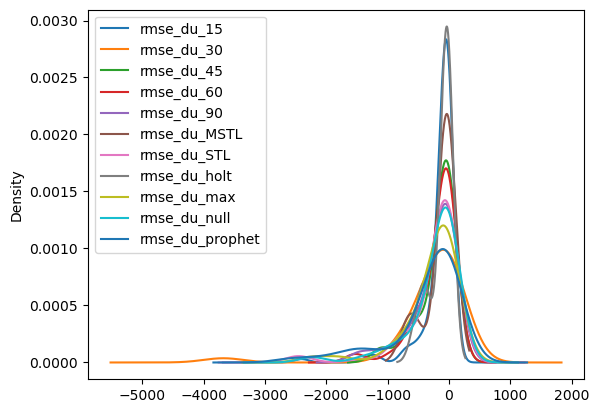

In [88]:
rmse_results_join.groupby("min_period")["price_delta_mean"].plot(kind='kde')
plt.legend()

In [97]:
rmse_results_join.to_excel("../../results/rmse_results_join_sku_metadata_v0.xlsx")